In [40]:
import json
import pandas as pd
import numpy as np

#### Load DAC data

In [41]:
data = []
#folder = '20210613T104026.162053h9cy9j52/'
# folder = '20210613T113528.189138l44w7_l_/'
#folder = 'direct_control_500_095/12345/'
folder = 'temp/12345/'
with open(folder + 'eval_infos_per_episode.json', 'r') as fh:
    for line in fh:
        jdata = json.loads(line)
        c = 0
        tmp = []
        for x in jdata:
            try:
                tmp.append(x[0]['values']['evals'])
            except:
                tmp.append(np.nan)
        data.append([np.nanmean(tmp), np.nanstd(tmp)])
data = np.array(data)

#### Load Theory Data

In [42]:
df = pd.read_csv('dyn_theory-0.95.csv')
mean_theory_evals = df[df.n == 500].mean().n_evals
std_theory_evals = df[df.n == 500].std().n_evals
print('Mean  | Standard Deviation')
print(mean_theory_evals, std_theory_evals)

Mean  | Standard Deviation
1446.8 299.77510868895314


#### Plot Evaluation Performance over Time

In [43]:
from matplotlib import pyplot as plt
import seaborn as sb

In [44]:
close_to_theory = np.where(data[:,0] <= mean_theory_evals + .5*std_theory_evals)[0]

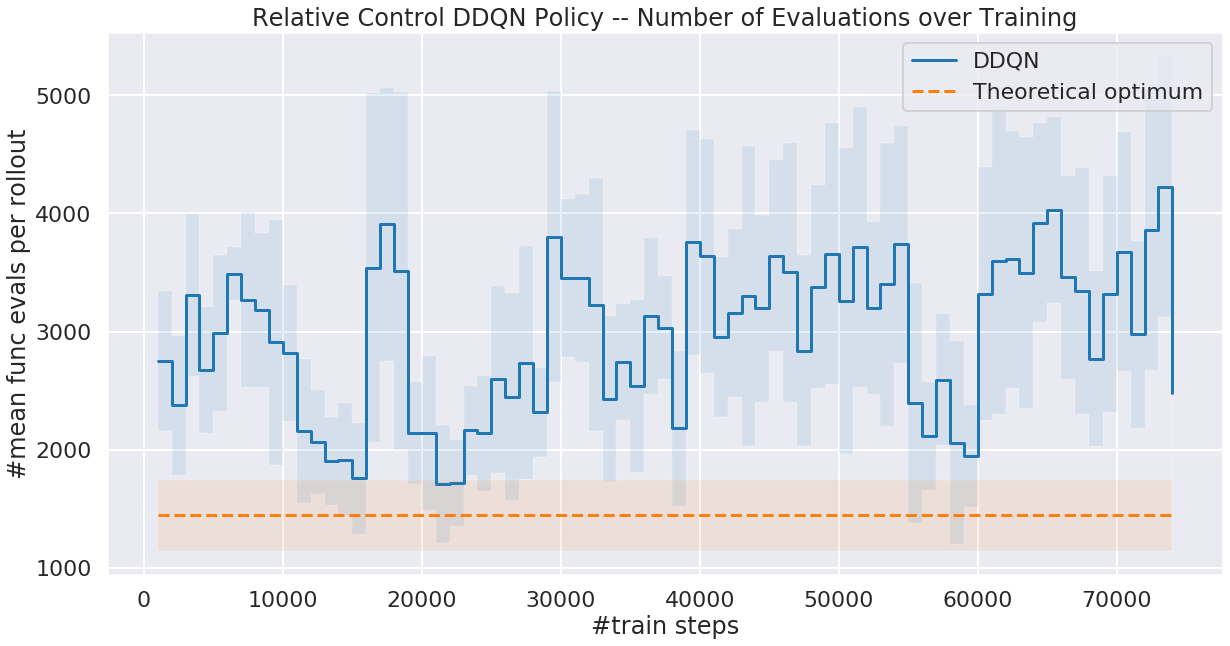

In [45]:
sb.set_style('darkgrid')
sb.set_context('poster')
fig = plt.figure(figsize=(20,10))
# DAC
plt.step(np.arange(1, len(data) + 1) * 1000, data[:,0], where='post',
         label='DDQN')
u = data[:, 0] + data[:, 1]
l = data[:, 0] - data[:, 1]
plt.fill_between(np.arange(1, len(data) + 1) * 1000, u, l, alpha=0.1, step='post')

# Theory
plt.step(np.arange(1, len(data) + 1) * 1000, [mean_theory_evals for _ in range(len(data))],
         ls='--', label='Theoretical optimum', where='post')
u = mean_theory_evals + std_theory_evals
l = mean_theory_evals - std_theory_evals
plt.fill_between(np.arange(1, len(data) + 1) * 1000, u, l, alpha=0.1, step='post')

# scatter points where we are close to theory
plt.scatter(np.arange(1, len(data) + 1)[close_to_theory] * 1000, data[close_to_theory,0])

plt.ylabel('#mean func evals per rollout')
plt.xlabel('#train steps')
plt.title('Relative Control DDQN Policy -- Number of Evaluations over Training')
plt.legend()
#plt.xlim([0, 100_000])
plt.show()

#### Print DAC policies that are close (in terms of number of evaluations) to the theoretical optimal one

In [46]:
with open(folder + 'eval_scores_per_inst.json', 'r') as fh:
    for idx, line in enumerate(fh):
        if idx in close_to_theory:
            tmp = json.loads(line)
            for policy in tmp['policies']:
                print(policy)
            print(tmp['reward_per_isnts'])
            print(data[idx])
            print('\n'*3)